# Efficient Algorithm for Time Series Retrieval
example of M4 data

## Imports and Setup

In [1]:
import locale
import os
import random
import re
import time
from typing import List, Tuple


from dtw import dtw, dtwPlotTwoWay, dtwPlotThreeWay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm.notebook import tqdm

locale.setlocale(locale.LC_ALL, '');
## fr ranges
start = -1
stop = 3
steps = 410
freq_ranges = 10**np.linspace(start,stop,steps)

# set comparison KPI
KPI = ['m', 'mean', 'std', 'q25', 'q50', 'q75', 'min', 'max']
DELTA_KPI = ['d_m', 'd_mean', 'd_std', 'd_q25', 'd_q50', 'd_q75', 'd_min', 'd_max']

# Visualization Setup
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set(font_scale=1.5)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Loading M4 Data

In [2]:
def read_m4_data(file_paths: List[str], path_prefix: str) -> pd.DataFrame:
    """ reads the  list given file paths and
        and combines them into a singular dataframe"""
    df_all = pd.DataFrame()
    
    for fpath in file_paths:
        start = time.time()
        df_tmp = pd.read_csv(path_prefix+fpath)
        end = time.time()
        execution_time = end - start
        print(f"file: {fpath} read in {execution_time:.2f} seconds\n\
        with {df_tmp.shape[0]:,d} rows and {df_tmp.shape[1]:,d} columns.\n")
        df_all = pd.concat([df_all, df_tmp])
        
    return df_all

In [3]:
# setting file paths
path_prefix_m4 = "/Users/philipp/workspace/UNIC/comp-593/m4_data/"
m4_paths = [
    "Hourly-train.csv",
    "Daily-train.csv",
    "Weekly-train.csv",
    "Monthly-train.csv",
    "Quarterly-train.csv",
    "Yearly-train.csv"
]

In [4]:

df_all_m4 = read_m4_data(m4_paths, path_prefix_m4)
print("###################\n")

file: Hourly-train.csv read in 0.11 seconds
        with 414 rows and 961 columns.

file: Daily-train.csv read in 15.05 seconds
        with 4,227 rows and 9,920 columns.

file: Weekly-train.csv read in 0.27 seconds
        with 359 rows and 2,598 columns.

file: Monthly-train.csv read in 17.00 seconds
        with 48,000 rows and 2,795 columns.

file: Quarterly-train.csv read in 1.62 seconds
        with 24,000 rows and 867 columns.

file: Yearly-train.csv read in 1.20 seconds
        with 23,000 rows and 836 columns.

###################



## Discard

In [5]:
def get_ucr_file_paths(path_prefix: str) -> Tuple[List[str],List[str]]:
  """creates a list file paths based on naming
  conventions of UCR archive"""
  ts_train_infos = []
  ts_test_infos = []
  for root, dirs, files in os.walk(path_prefix):
      for name in files:
          if(name.endswith("_TRAIN.tsv")):
              path_tmp = os.path.join(root,name)
              ts_name = re.split("/", root)[-1]
              ts_train_infos.append((ts_name, os.path.join(root,name)))
          elif(name.endswith("_TEST.tsv")):
              path_tmp = os.path.join(root,name)
              ts_name = re.split("/", root)[-1]
              ts_test_infos.append((ts_name, os.path.join(root,name)))
  return ts_train_infos, ts_test_infos

In [6]:
path_prefix_ucr = "/Users/philipp/workspace/UNIC/comp-593/data/ucr_data/UCRArchive_2018"
ts_train_paths, ts_test_paths = get_ucr_file_paths(path_prefix_ucr)

In [7]:
def load_ucr_files(train_paths: List[str], test_paths: List[str]) -> Tuple[pd.DataFrame,pd.DataFrame]:
    """load UCR archive files"""
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    for ts_info in tqdm(train_paths):
        ts_name = ts_info[0]
        fp = ts_info[1]

        df_tmp = pd.read_csv(fp, sep='\t', header=None)
        df_tmp['name'] = ts_name
        df_tmp['no'] = df_tmp.index
        cols = df_tmp.columns.tolist()
        cols = cols[-2:] + cols[:-2]
        df_tmp = df_tmp[cols]
        df_train = df_train.append(df_tmp)

    for ts_info in tqdm(test_paths):
        ts_name = ts_info[0]
        fp = ts_info[1]

        df_tmp = pd.read_csv(fp, sep='\t', header=None)
        df_tmp['name'] = ts_name
        df_tmp['no'] = df_tmp.index
        cols = df_tmp.columns.tolist()
        cols = cols[-2:] + cols[:-2]
        df_tmp = df_tmp[cols]
        df_test = df_test.append(df_tmp)
        
    return df_train, df_test
    

In [8]:
df_train, df_test = load_ucr_files(ts_train_paths, ts_test_paths)

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

## Load FFT conversion time series pool with statistics for M4

In [9]:
def extend_missing_freqs(freqs_l: list) -> list:
    """ ensure frequency length matches 5"""
    freqs_ext = [-1]*(5-len(freqs_l))
    freqs_ext.extend(freqs_l)
    return freqs_ext

In [61]:
# load m4 stats
df_m4_stats = pd.read_csv("../comp-593/data/df_stats_m4.csv", converters={"freq_ids": eval})
df_m4_stats["freq_ids"] = df_m4_stats["freq_ids"].apply(extend_missing_freqs)

# df_ucr_stats_test = pd.read_csv("../comp-593/data/df_ucr_stats_test.csv")

## M4 FFT transformation functions and top frequencies selection

In [11]:
def get_top_k_freq(PSD: np.array, freqs: np.array, k: int)->List[int]:
    """ return top k indexes with largest PSD val"""
    PSD = [np.real(val) for val in PSD]
    PSD_power_idx = sorted(range(len(PSD)), key= lambda x: PSD[x])[-k:]
    
    # find issue why digitize seems to find other frequencies than fft_2 script
    freq_apx_l = np.digitize(freqs, freq_ranges)
    freq_idx = [freq_apx_l[i] for i in PSD_power_idx]
    return freq_idx

In [12]:
def get_freq_m4(s: pd.Series, k:int=5) -> List[float]:
    """ compute frequencies for M4 pandas series"""
    df = pd.DataFrame()
    f=np.array(s.iloc[1:].dropna())
    n = f.size
    wdw = np.hamming(n)
    
    # FFT
    fhat = np.abs(np.fft.fft(f))
    PSD = fhat * np.conj(fhat) / n
    PSD = PSD.real
                   
    fft_freqs = np.arange(n)/n
    top_fft_apx = get_top_k_freq(PSD, fft_freqs, k)

    df_tmp = pd.DataFrame({
            "type": ["fft"],
            "freq_ids": [top_fft_apx]
                          })
    df = df.append(df_tmp)
    
    # Hamming
    fhat = np.fft.fft(f*wdw)
    PSD = np.real(fhat * np.conj(fhat) / n)

    
    hamming_freqs = np.arange(n)/n
    top_ham_apx = get_top_k_freq(PSD, hamming_freqs, k)
    df_tmp = pd.DataFrame({
            "type": ["Hamming"],
            "freq_ids": [top_ham_apx]
                          })
    df = df.append(df_tmp)
    
    # Welch
    seg_length = np.floor(1/20*n)
    if seg_length == 0:
        seg_length=10
    welch_freqs, PSD_welch = signal.welch(f, nperseg=seg_length,
                                      window='hamming')
    top_welch_apx = get_top_k_freq(PSD_welch, welch_freqs,k)
    df_tmp = pd.DataFrame({
            "type": ["Welch"],
            "freq_ids": [top_welch_apx]
                          })
    df = df.append(df_tmp)
    df.reset_index(inplace=True)
    return df

## discard

In [13]:
def get_freq_ucr(s: pd.Series, k:int=5) -> List[float]:
    """ compute frequencies for M4 pandas series"""
    df = pd.DataFrame()
    f=np.array(s.iloc[3:].dropna())
    n = f.size
    wdw = np.hamming(n)
    freq = np.arange(n)/n

    # FFT
    fhat = np.fft.fft(f)
    PSD = np.real(fhat * np.conj(fhat) / n)
    top_fft_idx = get_top_k_freq(PSD,k)
    fft_freq = freq[top_fft_idx]
    df_tmp = pd.DataFrame({
            "type": ["FFT"],
            "freq_ids": [top_fft_idx]
                          })
    df = df.append(df_tmp)
    # Hamming
    fhat = np.fft.fft(f*wdw)
    PSD = np.real(fhat * np.conj(fhat) / n)
    freq = np.arange(n)/f.size
    top_ham_idx = get_top_k_freq(PSD,k)
    ham_freq = freq[top_ham_idx]
    df_tmp = pd.DataFrame({
            "type": ["Hamming"],
            "freq_ids": [top_ham_idx]
                          })
    df = df.append(df_tmp)
    # Welch
    seg_length = np.floor(1/20*n)
    if seg_length == 0:
        seg_length=10
    welch_freqs, PSD_welch = signal.welch(f, nperseg=seg_length,
                                      window='hamming')
    top_welch_idx = get_top_k_freq(PSD_welch,k)
    welch_freq = freq[top_welch_idx]
    df_tmp = pd.DataFrame({
            "type": ["Welch"],
            "freq_ids": [top_welch_idx]
                          })
    df = df.append(df_tmp)
    
    return df

## Time Series handling and summary statistics computation

In [ ]:
def get_trend(ts_ar: np.ndarray,
                    periodicity: int) -> np.ndarray:
    if ts_ar.shape[0] < 2*periodicity:
        periodicity = math.floor(ts_ar.shape[0]/2)

    res = seasonal_decompose(ts_ar, 'additive', period=periodicity)

    return res.trend[~np.isnan(res.trend)]

def fit_trend(trend_ar: np.ndarray) -> Tuple[float,float]:
    fit_res = np.polyfit(np.arange(trend_ar.shape[0]), trend_ar, 1)
    m = fit_res[0]
    b = fit_res[1]
    return (m,b)

def get_ts_stats(s:pd.Series, archive:str="M4")->pd.Series:
    """ compute time series stats """
    if archive == "M4":
        ar = np.array(s[1:].dropna())
        ts_name = s[1]
    elif archive == "UCR":
        ar = np.array(s[3:].dropna())
    else:
        raise Exception("please set M4 or UCR as archive type")
    
    count = ar.shape[0]
    mean = np.mean(ar)
    std = np.std(ar)
    q25 = np.quantile(ar, .25)
    q50 = np.median(ar)
    q75 = np.quantile(ar, .75)
    max_val = np.max(ar)
    min_val = np.min(ar)
    
    period = 12
    trend_ar = get_trend(ar, period)
    m, b = fit_trend(trend_ar)
    
    if archive == "M4":
        idx = ['ts_name', 'm', 'b', 'count', 'mean', 'std', 'min',\
               'q25', 'q50', 'q75', 'max']
        res = pd.Series([ts_name, m, b, count, mean, std, min_val, q25, q50,\
                         q75, max_val], index=idx)
    else:
        idx = ['ts_name', 'no', 'class', 'm', 'b', 'count', 'mean', 'std', 'min',\
               'q25', 'q50', 'q75', 'max']
        res = pd.Series([ts_name, no, type_cls, count, m, b, mean, std, min_val, q25, q50,\
                         q75, max_val], index=idx)
    return res
        

In [ ]:
def top_freqs_2_list(s: pd.DataFrame, fr_ranges: np.ndarray) -> pd.Series:
    """ convert the list of frequencies into order """
    df_freqs = s.transpose()
    index_ = [s.iloc[0,1],"type"]
    df_freqs.index = index_
    df_freqs.iloc[0] = np.digitize(df_freqs.iloc[0],fr_ranges)
    return df_freqs.iloc[0]

### Match frequencies via Score

In [ ]:
def compute_match_scores(df_sub: pd.DataFrame,
                    freq_l: list) -> pd.Series:
    """ compute the match score for all time series
        in the pool of time series """
    # convert frequencies column to array
    candidates = np.array(list(df_sub['freq_ids'].to_list()))
    # handle cases where less that 5 top k frequencies
    # were identified    
    freq_l = extend_missing_freqs(freq_l)
    template_ar = np.array([freq_l]*candidates.shape[0])
    
    # match the frequencies
    match_ar =  candidates-template_ar
    mask = match_ar == 0
    indx = np.nonzero(mask)
    
    """
    on the matches apply 10 to power of column index
    and set non-matches to zero
    """
    match_ar[mask] = 10**(indx[1])
    match_ar[~mask] = 0

    match_scores = pd.Series(np.sum(match_ar, axis=1))
    df_sub.reset_index(inplace=True)
    df_sub["match_score"]=match_scores
    return df_sub

def find_max_matches(df_sub, freq_l) -> pd.DataFrame:
    """ find maximum matching score(s) """
    df_sub = compute_match_scores(df_sub, freq_l)
    
    # find maximum value
    max_f_match = df_sub["match_score"].max()

    # subset results to maximum match
    df_sub = df_sub[df_sub["match_score"]==max_f_match]
    return df_sub

def compute_stats_delta(s_templ_stats:pd.Series,
                        df_sub:pd.DataFrame):
    """ compute delta for each statistic in pool """
    kpis = s_templ_stats.index[1:].tolist()
    for kpi in kpis:
        d_kpi_name = "_".join(("d", kpi))
        d_kpi_val = abs(df_sub[kpi] - s_templ_stats[kpi])
        df_sub[d_kpi_name] = d_kpi_val
    return df_sub


def get_delta_min_ts(df_sub: pd.DataFrame, 
                     df_templ: pd.DataFrame,
                     templ_stats: pd.Series,
                     ts_name: str,
                    remove_templ:bool=True)-> pd.DataFrame:
    """ find the best matching frequencies
        and minimum delta for all defined KPI """
    if remove_templ:
        df_sub = df_sub[~(df_sub["ts_name"]==ts_name)]
        
    # get different FFT types
    l_types = df_templ["type"].unique().tolist()
    # process data per fft type
    df_matches = pd.DataFrame()
    for fft_type in l_types:
        df_tmp = find_max_matches(df_sub[df_sub["type"]==fft_type],
                                 df_templ[df_templ["type"]==fft_type]["freq_ids"].iloc[0])
        df_matches = df_matches.append(df_tmp)

    # compute stats deltas
    df_delta_stats = compute_stats_delta(templ_stats,
                                         df_matches)
    df_res = pd.DataFrame() # result dataframe
    
    # get min delta for all defined kpis
    for fft_tuple in df_delta_stats.groupby("type"):
        fft_type = fft_tuple[0]
        df_type_matches = fft_tuple[1]
        for i in range(len(DELTA_KPI)):
            d_kpi = DELTA_KPI[i]
            # check if results are sorting delta kpis correctly
            min_series = df_type_matches.sort_values(d_kpi).iloc[0,:] # best match for particular KPI
            df_tmp = pd.DataFrame({
                "ts_templ": ts_name,
                "fft_type": fft_type,
                "ts_match": min_series['ts_name'],
                "match_score": min_series["match_score"],
                "min_kpi": d_kpi,
                "value": min_series[d_kpi]
            }, index=[0])
            df_res = df_res.append(df_tmp)
    return df_res

## Test on Single Series
run-time for the algorithm starts here

In [62]:
s_test = df_all_m4.sample(1, random_state=41).squeeze() # select random series


### Test Time to run against converted time series pool

In [63]:
%%timeit
test_ts_stats = get_ts_stats(s_test); # get time series statistics
df_test_ts_freq = get_freq_m4(s_test); # get top frequencies for time series
ts_name = s_test[0] # name of time series
df_ts_res = get_delta_min_ts(df_m4_stats, df_test_ts_freq, test_ts_stats, ts_name);

/var/folders/9b/qts_zvv52g90t2t7r2t45drw0000gn/T/ipykernel_23050/2886081340.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["match_score"]=match_scores


730 ms ± 32.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Create actual results

In [64]:
test_ts_stats = get_ts_stats(s_test) # get time series statistics
df_test_ts_freq = get_freq_m4(s_test) # get top frequencies for time series
ts_name = s_test[0] # name of time series
df_ts_res = get_delta_min_ts(df_m4_stats, df_test_ts_freq, test_ts_stats, ts_name)

/var/folders/9b/qts_zvv52g90t2t7r2t45drw0000gn/T/ipykernel_23050/2886081340.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["match_score"]=match_scores


## Visualize Results

###  Time Series Visualization functions

In [57]:
def viz_template_ts(s:pd.Series):
    """ visualize template series """
    # prep data
    y = s.iloc[1:].dropna()
    x = np.linspace(0, y.shape[0],y.shape[0])
    ts_name = s.iloc[0]
    
    # set plot
    fig, ax = plt.subplots(figsize=(16,8))
    fig.suptitle('Template Series: '+ts_name, fontsize=20)
    ax.set(xlabel='steps', ylabel='values')
    ax = sns.lineplot(x=x, y=y )

def get_ts_by_name(df: pd.DataFrame,
            ts_name:str
            )->pd.Series:
    """ return based on name """      
    s = df[df["V1"]==ts_name].squeeze()
    return s

def get_match_ts_name(df_matches: pd.DataFrame,
                      fft_type: str,
                      match_kpi: str)->str:
    """ get name of time series matching criteria """
    print(fft_type, match_kpi)
    df_tmp = df_matches[(df_matches["fft_type"]==fft_type)&
                        (df_matches["min_kpi"]==match_kpi)]

    if df_tmp.shape[0] != 1:
        raise Exception("selection error")
    else:
        return df_tmp["ts_match"].iloc[0]

def viz_2_series(s_templ:pd.Series,
                 df_pool: pd.DataFrame,
                 df_matches: pd.DataFrame,
                fft_type: str=None,
                match_kpi: str=None)->None:
    """ visualize two matches """
                                
    # based on provided parameter complete choice with random selection    
    if fft_type == None:
        fft_type = random.choice(df_matches["fft_type"].unique().tolist())

    if match_kpi == None:
        match_kpi = random.choice(df_matches["min_kpi"].unique().tolist())
        
    match_name = get_match_ts_name(df_matches,
                                   fft_type,
                                   match_kpi)
      
    # get selected time series
    s_match = get_ts_by_name(df_pool, match_name)
    # prep data
    y_templ = s_templ.iloc[1:].dropna()
    y_match = s_match.iloc[1:].dropna()

    x_templ = np.linspace(0, y_templ.shape[0],y_templ.shape[0])
    x_match = np.linspace(0, y_match.shape[0],y_match.shape[0])
    # get names
    templ_name = s_templ.iloc[0]+ " (Template)"
    match_name = s_match.iloc[0]+ " (Match)"
    
    # plot
    fig, ax = plt.subplots(figsize=(16,8))
    title = f"Matching Single Time Series with\nWindow type: {fft_type} and KPI: {match_kpi}"
    fig.suptitle(title, fontsize=20)
    ax.set(xlabel='steps', ylabel='values')
    #ax.set
    ax = sns.lineplot(x=x_templ, y=y_templ, label=templ_name)
    ax = sns.lineplot(x=x_match, y=y_match, label=match_name)


### Visualize Template Time Series only

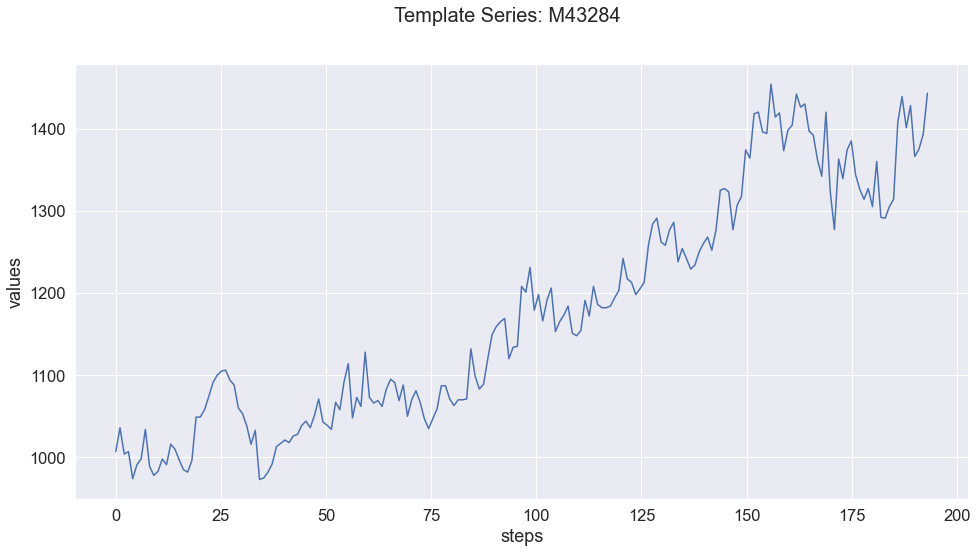

In [65]:
viz_template_ts(s_test)

### Visualize Single Match for Time Series with Window Type and Minimum KPI

Welch d_std


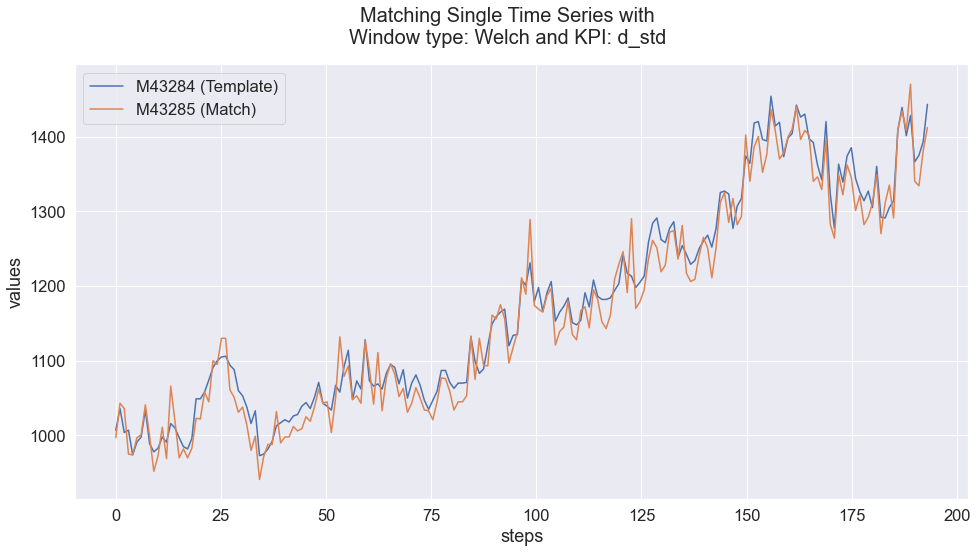

In [66]:
viz_2_series(s_test, df_all_m4, df_ts_res)

## DTW Match
Subset time series pool for reasonable execution time

In [23]:
def apply_dtw(row_test: pd.Series,
             ar_templ: np.ndarray):
    """ compute distance via dynamic time warping""" 
    ar_test = np.array(row_test.iloc[1:].dropna().to_numpy(dtype='float'))
    aln = dtw(ar_test, ar_templ, distance_only=True)  
    return aln.distance


### Subset time series pool size
(accommodate wait times)

In [53]:
df_dtw_sample = df_all_m4.sample(200)
print(f" DTW sample pool has {df_dtw_sample.shape[0]} entries")

 DTW sample pool has 200 entries


In [67]:
%%timeit
tqdm.pandas()
ts = np.array(s_test.iloc[1:].dropna().to_numpy(dtype='float'))
df_dtw_sample["distance"] = df_dtw_sample.progress_apply(apply_dtw, args=(ts,), axis=1)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

1.19 s ± 82.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
ts = np.array(s_test.iloc[1:].dropna().to_numpy(dtype='float'))

### Visualize DTW Results

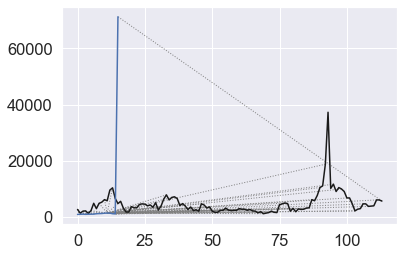

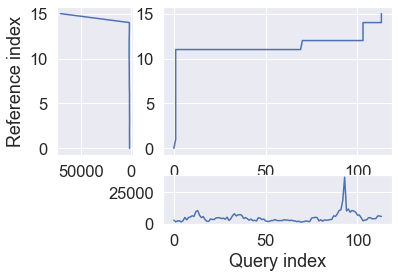

<AxesSubplot:>

In [68]:
df_dtw_sample.sort_values("distance", inplace=True)
match_name = df_dtw_sample.iloc[0,0]
ar_match = np.array(df_dtw_sample[df_dtw_sample['V1']==match_name].iloc[:,1:].dropna(axis=1))[0]
aln = dtw(ts, ar_match)

dtwPlotTwoWay(aln, ts, ar_match)
dtwPlotThreeWay(aln, ts, ar_match)
# remove actual time series from results